# Extract Feature Steps

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os, os.path
import fnmatch
import numpy as np
from scipy import misc
import pandas as pd
from skimage import color
from skimage import data
from skimage import measure
from skimage.filters import threshold_adaptive
from skimage.filters import threshold_otsu
from skimage.feature.texture import greycomatrix
from skimage.feature.texture import greycoprops
import skimage
from scipy.stats import kurtosis
from scipy.stats import skew
#%pylab inline
%matplotlib inline

## Extract Statisitcal Features
stattisitcal features are:
* Mean
* Variance
* Skew
* Kurtosis

In [2]:
def getStats(img, removeblack):
    data = img.flatten()
    if removeblack:
        index = np.argwhere(data==0)
        data = np.delete(data, index)
    return [np.mean(data), np.var(data), skew(data), kurtosis(data)]

## Convert Image to BitMap

Source Code http://tonysyu.github.io/scikit-image/auto_examples/plot_otsu.html

The threshould is picked by https://en.wikipedia.org/wiki/Otsu's_method

The image is then converted to bit map

In [3]:
def toBitMap(gray):
    thresh = threshold_otsu(gray)
    bitmap = np.dot((gray > thresh).astype(float),1)
    return bitmap

Count ratio between black and white ratios

In [4]:
def getBlackandWhiteCount(bitmaparray):
    total = len(bitmaparray.flatten())
    white = np.count_nonzero(bitmaparray.flatten())
    black = total-white
    return [black/total, white/total]

## GCLM Texture Features
Get Value of Texture src:http://scikit-image.org/docs/0.7.0/api/skimage.feature.texture.html

In [5]:
def GetCoMatrix(gray):
    newGray = (gray).astype(int)
    coMatrix = greycomatrix(newGray, [1], [0,np.pi/4,np.pi/2,3*np.pi/4], levels=256, normed=True, symmetric=True)
    return coMatrix

In [6]:
def GetTextureFeature(coMatrix,feature):
    featurevalues = greycoprops(coMatrix, feature)
    return featurevalues

In [7]:
def GetEntropy(coMatrix):
    I,J,D,A = coMatrix.shape
    shannon = np.zeros((D,A))
    for d in range(0,D):
        for a in range (0,A):
            shannon[d,a] = skimage.measure.shannon_entropy(coMatrix[:,:,d,a])
    return shannon

# Load Data

In [8]:
def files_within(directory_path, pattern="*"):
    for dirpath, dirnames, filenames in os.walk(directory_path):
        for file_name in fnmatch.filter(filenames, pattern):
            yield os.path.join(dirpath, file_name)

In [9]:
def LoadImages(path,ImgsType):
    imgs = []
    files = list(files_within(path,"*.jpg"))
    for file in files:
        #print(file)
        if ImgsType not in file: 
            continue
        img = Image.open(file)
        #img = img.resize((1024, 1024))
        img = np.array(img)
        print(file," ",img.shape)
        imgs.append(img)
    #imgs = np.array(imgs)
    print(len(imgs))
    return imgs

# Create Data Set

### Selected Features are:
* All Ranges Mean Value
* All Range Var
* All Ranges Skew
* All Ranges kurtosis
* Red Ranges Mean Value
* Red Range Var
* Red Ranges Skew
* Red Ranges kurtosis
* Green Ranges Mean Value
* Green Range Var
* Green Ranges Skew
* Green Ranges kurtosis
* Blue Ranges Mean Value
* Blue Range var
* Blue Ranges Skew
* Blue Ranges kurtosis
* Gray Ranges Mean Value
* Gray Range var
* Gray Ranges Skew
* Gray Ranges kurtosis
-------------------
* Black Ratio
* White Ratio
* Origional Entropy
* Contrast Effect (4)
* Dissimilarity Effect (4)
* Homogeneity (4)
* Energy (4)
* Correlation (4)
* Entropy (4)

In [10]:
columns = ["Amean","Avar","ASkew", "AKurt",
           "Rmean","Rvar","RSkew", "RKurt",
           "Gmean","Gvar","GSkew", "GKurt",
           "Bmean","Bvar","BSkew", "BKurt",
           "Graymean","Grayvar","GraySkew", "GrayKurt",
           "BlackRatio","WhiteRatio",
           "Entropy",
           "Contrast0","Contrast45","Contrast90","Contrast135",
           "Dissimilarity0","Dissimilarity45","Dissimilarity20","Dissimilarity2PI/2",
           "Homogeneity0","Homogeneity45","Homogeneity90","Homogeneity135",
           "Energy0","Energy45","Energy20","Energy135",
           "Correlation0","Correlation45","Correlation90","Correlation135",
           "Entropy0","Entropy45","Entropy90","Entropy135"
          ]

In [11]:
def allWork(path,ImgsType, removeblack = True):
    imgs = LoadImages(path,ImgsType)
    data = []
    for i in range(0,len(imgs)):
        Astats = getStats(imgs[i],removeblack)
        Rstats = getStats(imgs[i][:,:,0],removeblack)
        Gstats = getStats(imgs[i][:,:,1],removeblack)
        Bstats = getStats(imgs[i][:,:,2],removeblack)
        Gray = color.rgb2gray(imgs[i])*255 #* 255 # * 255 due to scale issues (0-1) -> (0->255)
        Graystats = getStats(Gray,removeblack)
        
        #black and white ratios and entropy
        [b,w] = getBlackandWhiteCount(toBitMap(Gray))
        origionalentropy = skimage.measure.shannon_entropy(Gray)
        
        #texture features
        coMatrix = GetCoMatrix(Gray)
        contrast = GetTextureFeature(coMatrix,'contrast')
        dissimilarity = GetTextureFeature(coMatrix,'dissimilarity')
        homogeneity = GetTextureFeature(coMatrix,'homogeneity')
        energy = GetTextureFeature(coMatrix,'energy')
        correlation = GetTextureFeature(coMatrix,'correlation')
        entropy = GetEntropy(coMatrix)
    
        data.append([ Astats[0],Astats[1],Astats[2],Astats[3],  
                     Rstats[0],Rstats[1],Rstats[2],Rstats[3], 
                     Gstats[0],Gstats[1],Gstats[2],Gstats[3], 
                     Bstats[0],Bstats[1],Bstats[2],Bstats[3],
                     Graystats[0],Graystats[1],Graystats[2],Graystats[3],
                     b, w,
                     origionalentropy,
                     contrast[0][0], contrast[0][1], contrast[0][2],contrast[0][3],
                     dissimilarity[0][0],dissimilarity[0][1],dissimilarity[0][2],dissimilarity[0][3],
                     homogeneity[0][0],homogeneity[0][1],homogeneity[0][2],homogeneity[0][3],
                     energy[0][0],energy[0][1],energy[0][2],energy[0][3],
                     correlation[0][0],correlation[0][1],correlation[0][2],correlation[0][3],
                     entropy[0][0],entropy[0][1],entropy[0][2],entropy[0][3]
                    ])

    numpyarray = np.array(data)
    df = pd.DataFrame(numpyarray, columns = columns)
    return df

In [12]:
path = "."
types = "No BG"
removeblack = False
df = allWork(path,types,removeblack)
df['Class'] = ['80-100 %','0-20 %','20-40 %','40-60 %','60-80 %','Clean']

.\No BG\100-GOPR1306-frame700.jpg   (733, 1352, 3)
.\No BG\20_GOPR1027-frame150.jpg   (733, 1352, 3)
.\No BG\40-GOPR0978-frame0.jpg   (733, 1352, 3)
.\No BG\60-GOPR1180-frame840.jpg   (733, 1352, 3)
.\No BG\80-GOPR1225-frame700.jpg   (733, 1352, 3)
.\No BG\Clean_GOPR0943.JPG   (995, 1368, 3)
6


C:\Users\eng_w\Anaconda3\lib\site-packages\skimage\feature\texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


In [13]:
df.head(6)

,Amean,Avar,ASkew,AKurt,Rmean,Rvar,RSkew,RKurt,Gmean,Gvar,...,Energy135,Correlation0,Correlation45,Correlation90,Correlation135,Entropy0,Entropy45,Entropy90,Entropy135,Class
0,96.312695,4321.206291,-0.524715,-1.303325,99.008617,4657.859048,-0.533703,-1.413014,95.708824,4304.097520,...,0.267179,0.978597,0.962570,0.976156,0.964770,9.326280,9.551958,9.401087,9.535499,80-100 %
1,74.184168,3901.586475,0.602104,-0.070672,69.664411,3830.476668,0.798558,0.168317,71.255210,3774.364323,...,0.279202,0.958682,0.895113,0.930258,0.901453,9.759935,10.215565,9.841503,10.190715,0-20 %
2,64.530801,3955.310665,0.707938,-0.215533,62.146934,3939.187172,0.819901,-0.090614,63.067005,3899.226012,...,0.360748,0.948615,0.897487,0.934894,0.900305,9.435021,9.766103,9.512679,9.758853,20-40 %
3,83.710363,4187.112150,0.019733,-1.218548,83.648385,4423.649424,0.084965,-1.289224,81.888749,4131.528726,...,0.273817,0.960334,0.930389,0.955933,0.931612,10.422224,10.723867,10.468105,10.717977,40-60 %
4,100.670398,3654.913091,-0.599230,-0.959015,101.037593,3879.646515,-0.537662,-1.114812,99.056432,3624.293607,...,0.192790,0.961008,0.928059,0.949483,0.927735,10.820810,11.118904,10.922601,11.117277,60-80 %
5,32.212409,2310.528376,1.526814,2.188046,22.769876,1341.953671,2.339998,7.265098,30.701513,1971.145844,...,0.614328,0.960363,0.825780,0.861031,0.833033,5.310230,5.481365,5.290292,5.475499,Clean


In [17]:
df.to_csv("Yap.csv",index=False)

In [78]:
neededColumns = ['AKurt','Rmean','RKurt','GKurt','BKurt','Graymean','GrayKurt','Contrast45','Contrast90','Contrast135']


In [82]:
from sklearn.preprocessing import MinMaxScaler
df1 = df[neededColumns]
y = df['Class']
#scaler = MinMaxScaler()
#df1 = scaler.fit_transform(df1)
dfinal = pd.DataFrame(df1, columns = neededColumns)
dfinal['Class'] = y
b, c = dfinal.iloc[0], dfinal.iloc[5]
temp = dfinal.iloc[0].copy()
dfinal.iloc[0] = c
dfinal.iloc[5] = temp
dfinal.T.head(100)

,0,1,2,3,4,5
AKurt,-0.941632,-0.733398,-0.832182,-0.443304,0.452397,2.90083
Rmean,119.532,118.762,120.782,128.866,130.47,136.351
RKurt,-1.48459,-1.07736,-1.0599,-0.639085,0.143892,2.77103
GKurt,-1.31612,-0.921634,-0.974355,-0.558741,0.312817,2.91245
BKurt,-0.349288,0.0104901,-0.379692,-0.161442,0.854348,3.08076
Graymean,126.782,119.633,121.496,127.454,129.203,133.906
GrayKurt,-1.34612,-0.918305,-0.967474,-0.558797,0.30174,2.89744
Contrast45,369.768,738.964,732.713,566.991,506.891,313.681
Contrast90,255.943,501.416,470.651,364.084,353.414,208.009
Contrast135,348.264,693.698,723.243,558.409,511.557,286.073


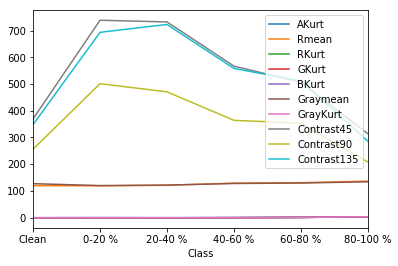

In [80]:
dfinal.plot(x= 'Class')